In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

import os
import glob

# --- 1. Load and preprocess dynamically from folder ---

def load_and_prepare(path, suffix):
    df = pd.read_csv(path, parse_dates=['valid_time'])
    df = df.sort_values('valid_time')
    df['tp'] *= 1000  # Convert m to mm
    df = df[['valid_time', 'u10', 'v10', 't2m', 'sp', 'tp']]
    df.columns = ['valid_time'] + [f'{col}_{suffix}' for col in df.columns if col != 'valid_time']
    return df

# New path for updated data
data_folder = 'brazil/'

# Find all CSV files
file_paths = glob.glob(os.path.join(data_folder, '*.csv'))

# Extract suffixes from file names (e.g. 'brazil/n2e.csv' -> 'n2e')
region_suffixes = [os.path.splitext(os.path.basename(f))[0] for f in file_paths]

# Load all regions
dfs_by_region = [load_and_prepare(path, suffix) for path, suffix in zip(file_paths, region_suffixes)]

# Merge all dataframes on 'valid_time'
df = dfs_by_region[0]
for regional_df in dfs_by_region[1:]:
    df = df.merge(regional_df, on='valid_time')

df = df.sort_values('valid_time').reset_index(drop=True)


# 2. Add cyclical time features
df['dayofyear'] = df['valid_time'].dt.dayofyear
df['dayofyear_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
df['dayofyear_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365)

# 3. Define feature groups
# Dynamically use suffixes from filenames
regions = region_suffixes


from sklearn.preprocessing import StandardScaler

# 1. Collect all meteorological input features from all regions
all_meteorological_features = []
for region in regions:
    all_meteorological_features += [f'{var}_{region}' for var in ['u10', 'v10', 't2m', 'sp', 'tp']]

# 2. Train-test split index (time based)
train_size = int(0.6 * len(df))  # You can also use timestamp slicing if needed

# 3. Scale meteorological features
scaler = StandardScaler()
df[all_meteorological_features] = scaler.fit_transform(df[all_meteorological_features].copy())

# 4. Scale target (tp_c) separately — the variable you're trying to predict
tp_scaler = StandardScaler()
df['tp_c_scaled'] = tp_scaler.fit_transform(df[['tp_c']].copy())

# 5. Temporal features: lag, rolling mean, difference on center precipitation
lags = [1, 3, 6, 12, 24]
rolling_windows = [3, 6, 12]

for lag in lags:
    df[f'tp_lag_{lag}h'] = df['tp_c'].shift(lag)

for window in rolling_windows:
    df[f'tp_roll_mean_{window}h'] = df['tp_c'].rolling(window).mean()

df['tp_diff_1h'] = df['tp_c'].diff()



# 7. Wind features
wind_feature_dict = {}
for region in regions:
    u = f'u10_{region}'
    v = f'v10_{region}'
    wind_speed = np.sqrt(df[u] ** 2 + df[v] ** 2)
    wind_dir = (np.arctan2(df[v], df[u]) * 180 / np.pi + 360) % 360

    wind_feature_dict[f'wind_speed_{region}'] = wind_speed
    wind_feature_dict[f'wind_direction_{region}'] = wind_dir
    wind_feature_dict[f'wind_speed_change_{region}'] = wind_speed.diff()
    wind_feature_dict[f'wind_direction_change_{region}'] = wind_dir.diff()

# 8. Wind-rain interactions
interaction_feature_dict = {}
for region in regions:
    interaction_feature_dict[f'wind_rain_local_{region}'] = wind_feature_dict[f'wind_speed_{region}'] * df[f'tp_{region}']
    if region != 'c':
        interaction_feature_dict[f'wind_to_center_rain_{region}'] = wind_feature_dict[f'wind_speed_{region}'] * df['tp_c'].shift(1)

# 9. Synoptic gradients and trends

# Define directional aliases manually (these are approximate and depend on your grid naming)
# You can update these if you use different suffixes
region_aliases = {
    'north': 'n',
    'south': 's',
    'east':  'e',
    'west':  'w',
    'center': 'c'
}

def safe_diff(var, r1, r2):
    try:
        return df[f'{var}_{r1}'] - df[f'{var}_{r2}']
    except KeyError:
        return pd.Series(np.nan, index=df.index)

grad_features = {
    # Gradients
    'sp_gradient_ns': safe_diff('sp', region_aliases['north'], region_aliases['south']),
    'sp_gradient_ew': safe_diff('sp', region_aliases['east'], region_aliases['west']),
    't2m_gradient_ns': safe_diff('t2m', region_aliases['north'], region_aliases['south']),
    't2m_gradient_ew': safe_diff('t2m', region_aliases['east'], region_aliases['west']),

    # Divergence
    'u10_divergence': safe_diff('u10', region_aliases['east'], region_aliases['west']),
    'v10_divergence': safe_diff('v10', region_aliases['north'], region_aliases['south']),

    # Trends at center
    'sp_center_trend': df[f'sp_{region_aliases["center"]}'].diff(),
    't2m_center_trend': df[f't2m_{region_aliases["center"]}'].diff(),
    'sp_center_trend_6h': df[f'sp_{region_aliases["center"]}'].rolling(6).mean().diff(),

    # Slopes (center minus neighbor)
    'sp_slope_north': safe_diff('sp', region_aliases['center'], region_aliases['north']),
    'sp_slope_south': safe_diff('sp', region_aliases['center'], region_aliases['south']),
    'sp_slope_east':  safe_diff('sp', region_aliases['center'], region_aliases['east']),
    'sp_slope_west':  safe_diff('sp', region_aliases['center'], region_aliases['west']),

    # Wind at center
    'wind_speed_center': np.sqrt(df[f'u10_{region_aliases["center"]}'] ** 2 + df[f'v10_{region_aliases["center"]}'] ** 2),
    'wind_dir_center': np.arctan2(df[f'v10_{region_aliases["center"]}'], df[f'u10_{region_aliases["center"]}']),
}

# Magnitudes
grad_features['sp_gradient_mag'] = lambda d: np.sqrt(d['sp_gradient_ns']**2 + d['sp_gradient_ew']**2)
grad_features['t2m_gradient_mag'] = lambda d: np.sqrt(d['t2m_gradient_ns']**2 + d['t2m_gradient_ew']**2)
grad_features['wind_divergence'] = lambda d: d['u10_divergence'] + d['v10_divergence']

# Evaluate lambda functions
for k, v in grad_features.items():
    if callable(v):
        grad_features[k] = v(grad_features)

# 10. Concatenate all new features at once
df = pd.concat([
    df,
    pd.DataFrame(wind_feature_dict, index=df.index),
    pd.DataFrame(interaction_feature_dict, index=df.index),
    pd.DataFrame(grad_features, index=df.index),
], axis=1)

# 11. Drop NaNs from lag/rolling/diff
df.dropna(inplace=True)

# 12. De-fragment the DataFrame (optional but recommended)
df = df.copy()

# === Feature Name Lists ===

# Lag, rolling, diff (assume already defined: lags, rolling_windows)
lag_features   = [f'tp_lag_{lag}h' for lag in lags]
roll_features  = [f'tp_roll_mean_{w}h' for w in rolling_windows]
diff_features  = ['tp_diff_1h']
cyclical_features = ['dayofyear_sin', 'dayofyear_cos']

# Wind features
wind_features = []
for region in regions:
    wind_features += [
        f'wind_speed_{region}',
        f'wind_direction_{region}',
        f'wind_speed_change_{region}',
        f'wind_direction_change_{region}'
    ]

# Wind-rain interaction features
interaction_features = []
for region in regions:
    interaction_features.append(f'wind_rain_local_{region}')
    if region != 'c':
        interaction_features.append(f'wind_to_center_rain_{region}')

# Front/synoptic features
front_features = list(grad_features.keys())

# Final derived features
derived_features = (
    wind_features +
    lag_features +
    roll_features +
    diff_features +
    interaction_features +
    cyclical_features +
    front_features
)



# Scale all derived features
scaler_derived = StandardScaler()
df[derived_features] = scaler_derived.fit_transform(df[derived_features])

# Final feature columns for model input
feature_cols = all_meteorological_features + derived_features

feature_cols = list(dict.fromkeys(feature_cols))  # Keeps order, removes duplicates

# Optional: check and report
dupes = [col for col in feature_cols if feature_cols.count(col) > 1]
if dupes:
    print(f"Duplicate feature columns removed: {dupes}")
else:
    print("No duplicate feature columns.")



print(f"Final feature columns count: {len(feature_cols)}")
print(f"Length of df after processing: {len(df)}")


# Original sequence creation (short sequences)
def create_sequences(df, seq_len=5, horizon=7):
    X, y = [], []
    for i in range(seq_len, len(df) - horizon):
        X.append(df.iloc[i - seq_len:i][feature_cols].values.astype(np.float32))
        y.append(df.iloc[i:i + horizon]['tp_c_scaled'].values.astype(np.float32))
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)


sequence_length = 5
forecast_horizon = 7
X, y = create_sequences(df, sequence_length, forecast_horizon)
print(f"X shape: {X.shape}, y shape: {y.shape}")

# Rain classification (multi-class)

y_mm = y
y_rain_class = np.digitize(y_mm, bins=[0.1, 0.5, 2.0, 10.0])  # shape: (samples, horizon)

# Prepare long-input sequences
def create_long_sequences(df, long_seq_len=24, horizon=7):
    X_long = []
    for i in range(long_seq_len, len(df) - horizon):
        X_long.append(df.iloc[i - long_seq_len:i][feature_cols].values.astype(np.float32))
    return np.array(X_long, dtype=np.float32)

X_long = create_long_sequences(df, long_seq_len=24, horizon=forecast_horizon)
offset = len(X) - len(X_long)
X = X[offset:]
y = y[offset:]
y_rain_class = y_rain_class[offset:]

# Interaction inputs
# def create_interaction_inputs(df, interaction_features, seq_len=5, horizon=7):
#     X_wind = []
#     for i in range(seq_len, len(df) - horizon):
#         X_wind.append(df.iloc[i][interaction_features].values.astype(np.float32))
#     return np.array(X_wind, dtype=np.float32)

def create_interaction_inputs(df, interaction_features, seq_len=5, horizon=7):
    X_wind = []
    for i in range(seq_len, len(df) - horizon):
        # Take full seq_len window of interaction features ending at current i
        seq_window = df.iloc[i - seq_len:i][interaction_features].values.astype(np.float32)
        X_wind.append(seq_window)
    return np.array(X_wind, dtype=np.float32)


X_wind = create_interaction_inputs(df, interaction_features, sequence_length, forecast_horizon)



feature_dim = len(feature_cols) + len(interaction_features)

# feature_cols = feature_cols + interaction_features
feature_cols = list(dict.fromkeys(feature_cols + interaction_features))

X, y = create_sequences(df, sequence_length, forecast_horizon)
X_long = create_long_sequences(df, long_seq_len=24, horizon=forecast_horizon)

# Splitting into train/val/test
train_size = int(0.6 * len(X))
val_size   = int(0.2 * len(X))

X_train = X[:train_size]
X_val   = X[train_size:train_size + val_size]
X_test  = X[train_size + val_size:]

y_train = y[:train_size]
y_val   = y[train_size:train_size + val_size]
y_test  = y[train_size + val_size:]

y_rain_train = y_rain_class[:train_size]
y_rain_val   = y_rain_class[train_size:train_size + val_size]
y_rain_test  = y_rain_class[train_size + val_size:]

X_long_train = X_long[:train_size]
X_long_val   = X_long[train_size:train_size + val_size]
X_long_test  = X_long[train_size + val_size:]

# Align X_wind with the final X before splitting
X_wind = X_wind[:len(X)]  # Force same number of samples

# Then do the splits again
X_wind_train = X_wind[:train_size]
X_wind_val   = X_wind[train_size:train_size + val_size]
X_wind_test  = X_wind[train_size + val_size:]

# Sequence generation & splitting

# 1. Set sequence lengths
sequence_length = 5
long_sequence_length = 24  # or 96, if memory-constrained
forecast_horizon = 7

# 2. Get valid sequence indices
max_seq_start = max(sequence_length, long_sequence_length)
end = len(df) - forecast_horizon
valid_indices = np.arange(max_seq_start, end)

# 3. Create aligned sequences
X = np.array([
    df.iloc[i - sequence_length:i][feature_cols].values.astype(np.float32)
    for i in valid_indices
])

X_long = np.array([
    df.iloc[i - long_sequence_length:i][feature_cols].values.astype(np.float32)
    for i in valid_indices
])

y = np.array([
    df.iloc[i:i + forecast_horizon]['tp_c_scaled'].values.astype(np.float32)
    for i in valid_indices
])

# 4. Rain classification targets
y_mm = np.expm1(y)
y_rain_class = np.digitize(y_mm, bins=[0.1, 0.5, 2.0, 10.0])

# 5. Interaction features
X_wind = np.array([
    df.iloc[i][interaction_features].values.astype(np.float32)
    for i in valid_indices
])

# 6. Time features
X_time = df.loc[valid_indices, ['dayofyear_sin', 'dayofyear_cos']].values.astype(np.float32)

# 7. Split into train/val/test
total = len(valid_indices)
train_size = int(0.6 * total)
val_size   = int(0.2 * total)

def split(arr):
    return arr[:train_size], arr[train_size:train_size + val_size], arr[train_size + val_size:]

X_train, X_val, X_test = split(X)
X_long_train, X_long_val, X_long_test = split(X_long)
y_train, y_val, y_test = split(y)
y_rain_train, y_rain_val, y_rain_test = split(y_rain_class)
X_wind_train, X_wind_val, X_wind_test = split(X_wind)
X_time_train, X_time_val, X_time_test = split(X_time)

# 8. Final shape checks
print("Shapes:")
print("X_train:", X_train.shape)
print("X_long_train:", X_long_train.shape)
print("y_train:", y_train.shape)
print("y_rain_train:", y_rain_train.shape)
print("X_wind_train:", X_wind_train.shape)
print("X_time_train:", X_time_train.shape)

# 9. Final assertions
assert X_train.shape[0] == X_long_train.shape[0] == y_train.shape[0] == y_rain_train.shape[0] == X_wind_train.shape[0] == X_time_train.shape[0]
assert X_val.shape[0]   == X_long_val.shape[0]   == y_val.shape[0]   == y_rain_val.shape[0]   == X_wind_val.shape[0]   == X_time_val.shape[0]
assert X_test.shape[0]  == X_long_test.shape[0]  == y_test.shape[0]  == y_rain_test.shape[0]  == X_wind_test.shape[0]  == X_time_test.shape[0]

#note, be VERY careful if modifying, check no data leaks between splits, can use libraries but less robust than manual splitting (easier and more reproducable though)

C:\Users\justa\AppData\Local\Temp\ipykernel_15968\2343149423.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['tp_c_scaled'] = tp_scaler.fit_transform(df[['tp_c']].copy())
C:\Users\justa\AppData\Local\Temp\ipykernel_15968\2343149423.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'tp_lag_{lag}h'] = df['tp_c'].shift(lag)
C:\Users\justa\AppData\Local\Temp\ipykernel_15968\2343149423.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

No duplicate feature columns.
Final feature columns count: 303
Length of df after processing: 61368
X shape: (61356, 5, 303), y shape: (61356, 7)
Shapes:
X_train: (36802, 5, 303)
X_long_train: (36802, 24, 303)
y_train: (36802, 7)
y_rain_train: (36802, 7)
X_wind_train: (36802, 49)
X_time_train: (36802, 2)


In [2]:
# --- Feature splits using actual region suffixes ---
# Use region_suffixes that were extracted earlier from filenames
regions = region_suffixes  # Make sure this is already defined earlier

# Helper function to check if a feature name ends with a region suffix
def is_per_region(feature_name):
    return any(feature_name.endswith(f"_{region}") for region in regions)

# Split features into per-region and non-per-region
per_region_features = [f for f in feature_cols if is_per_region(f)]
non_region_features = [f for f in feature_cols if not is_per_region(f)]

# Check the numbers
len_per_region = len(per_region_features)
extra_features = len(feature_cols) - len_per_region

print(f"Per-region features: {len_per_region}")
print(f"Extra (non-region) features: {extra_features}")
print(f"Non-region features: {non_region_features}")


#remapping for classifier
def remap_rain_class(y_rain):
    # Flatten if needed
    y_rain_flat = y_rain.flatten()
    
    new_labels = []
    for val in y_rain_flat:
        if val <= 0.1:
            new_labels.append(0)  # No Rain
        elif val <= 2.0:
            new_labels.append(1)  # Light Rain
        elif val <= 10.0:
            new_labels.append(2)  # Moderate Rain
        else:
            new_labels.append(3)  # Heavy Rain
    return np.array(new_labels).reshape(y_rain.shape)

# Re-binning rain classes from regression targets (or original class targets)
y_rain_train_new = remap_rain_class(y_rain_train)
y_rain_val_new = remap_rain_class(y_rain_val)
y_rain_test_new = remap_rain_class(y_rain_test)

# One-hot encode
from tensorflow.keras.utils import to_categorical
num_classes = 4
y_rain_train_cat = to_categorical(y_rain_train_new, num_classes=num_classes)
y_rain_val_cat = to_categorical(y_rain_val_new, num_classes=num_classes)
y_rain_test_cat = to_categorical(y_rain_test_new, num_classes=num_classes)

Per-region features: 274
Extra (non-region) features: 29
Non-region features: ['tp_lag_1h', 'tp_lag_3h', 'tp_lag_6h', 'tp_lag_12h', 'tp_lag_24h', 'tp_roll_mean_3h', 'tp_roll_mean_6h', 'tp_roll_mean_12h', 'tp_diff_1h', 'dayofyear_sin', 'dayofyear_cos', 'sp_gradient_ns', 'sp_gradient_ew', 't2m_gradient_ns', 't2m_gradient_ew', 'u10_divergence', 'v10_divergence', 'sp_center_trend', 't2m_center_trend', 'sp_center_trend_6h', 'sp_slope_north', 'sp_slope_south', 'sp_slope_east', 'sp_slope_west', 'wind_speed_center', 'wind_dir_center', 'sp_gradient_mag', 't2m_gradient_mag', 'wind_divergence']


In [ ]:
import numpy as np

# Assume these variables are defined already:
# df, feature_cols, sequence_length, forecast_horizon, regions

# 1. Compute number of regions and interaction dims
num_regions = len(regions)
interaction_dim = len(interaction_features)  # total interaction features

# Calculate extra wind dim per region in interaction features:
# Since interaction_features contain features per region, we can count how many per region:
features_per_region_interaction = None
if interaction_dim % num_regions == 0:
    features_per_region_interaction = interaction_dim // num_regions
else:
    # Just a fallback if interaction features are not evenly split
    print("Warning: interaction_features count not divisible by number of regions")
    features_per_region_interaction = 1  # fallback, adjust if needed

print(f"Interaction features total: {interaction_dim}, per region: {features_per_region_interaction}")

# 2. Get valid indices for sequences
max_seq_len = max(sequence_length, 24)  # or long_sequence_length
end_idx = len(df) - forecast_horizon
valid_indices = np.arange(max_seq_len, end_idx)

# 3. Create base X sequences (should already exist, but for completeness)
X = np.array([
    df.iloc[i - sequence_length:i][feature_cols].values.astype(np.float32)
    for i in valid_indices
])

X_long = np.array([
    df.iloc[i - 24:i][feature_cols].values.astype(np.float32)
    for i in valid_indices
])

# 4. Create static interaction features (current timestep)
X_wind_static = np.array([
    df.iloc[i][interaction_features].values.astype(np.float32)
    for i in valid_indices
])

# 5. Create interaction feature sequences (sequence_length window)
def create_interaction_sequence(df, features, seq_len, horizon):
    seqs = []
    for i in range(seq_len, len(df) - horizon):
        window = df.iloc[i - seq_len:i][features].values.astype(np.float32)
        seqs.append(window)
    return np.array(seqs)

X_wind_seq = create_interaction_sequence(df, interaction_features, sequence_length, forecast_horizon)

# 6. Reshape X_wind_seq to (samples, seq_len, num_regions, features_per_region)
# Ensure that interaction features are evenly divisible by the number of regions
features_per_region_interaction = len(interaction_features) // num_regions
# Calculate how many extra features we need to pad to make the interaction features divisible by num_regions
extra_features = (num_regions - len(interaction_features) % num_regions) % num_regions
padded_interaction_features = interaction_features + ['padding_feature'] * extra_features

# Now calculate the new features per region after padding
features_per_region_interaction = len(padded_interaction_features) // num_regions

# Create interaction feature sequences with the padded interaction features
# Calculate how many extra features we need to pad to make the interaction features divisible by num_regions
extra_features = (num_regions - len(interaction_features) % num_regions) % num_regions

# Add padding features to the interaction features (without needing to reference the DataFrame directly)
padded_interaction_features = interaction_features + ['padding_feature'] * extra_features

# Now calculate the new features per region after padding
features_per_region_interaction = len(padded_interaction_features) // num_regions

# Create interaction feature sequences with the padded interaction features (don't need to reference df)
X_wind_seq = create_interaction_sequence(df, padded_interaction_features, sequence_length, forecast_horizon)

# Reshape the sequences into the correct shape
X_wind_seq = X_wind_seq.reshape((-1, sequence_length, num_regions, features_per_region_interaction))



# Calculate the expected shape and reshape the data accordingly
# X_wind_seq = X_wind_seq.reshape((-1, sequence_length, num_regions, features_per_region_interaction))


# 7. Create targets and rain classes (assuming 'tp_c_scaled' exists)
y = np.array([
    df.iloc[i:i + forecast_horizon]['tp_c_scaled'].values.astype(np.float32)
    for i in valid_indices
])

# Rain classification from mm-scale rain (expm1)
y_mm = np.expm1(y)
y_rain_class = np.digitize(y_mm, bins=[0.1, 0.5, 2.0, 10.0])

# 8. Split function
def split_data(arr):
    total = len(arr)
    train_size = int(0.6 * total)
    val_size = int(0.2 * total)
    return arr[:train_size], arr[train_size:train_size + val_size], arr[train_size + val_size:]

# 9. Split all arrays
X_train, X_val, X_test = split_data(X)
X_long_train, X_long_val, X_long_test = split_data(X_long)
X_wind_static_train, X_wind_static_val, X_wind_static_test = split_data(X_wind_static)
X_wind_seq_train, X_wind_seq_val, X_wind_seq_test = split_data(X_wind_seq)
y_train, y_val, y_test = split_data(y)
y_rain_train, y_rain_val, y_rain_test = split_data(y_rain_class)

# 10. (Optional) Create time features if needed here, e.g. dayofyear sin/cos (adjust as per your code)
X_time = df.loc[valid_indices, ['dayofyear_sin', 'dayofyear_cos']].values.astype(np.float32)
X_time_train, X_time_val, X_time_test = split_data(X_time)
# 1. Build front sequences for short-term input (same seq_len = 5)
X_front_seq = np.array([
    df.iloc[i - sequence_length:i][front_features].values.astype(np.float32)
    for i in valid_indices
])

# 2. Split into train/val/test
X_front_train, X_front_val, X_front_test = split_data(X_front_seq)

# 11. Check shapes
print("Shapes after splitting:")
print(f"X_train: {X_train.shape}")
print(f"X_long_train: {X_long_train.shape}")
print(f"X_wind_static_train: {X_wind_static_train.shape}")
print(f"X_wind_seq_train: {X_wind_seq_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_rain_train: {y_rain_train.shape}")
print(f"X_time_train: {X_time_train.shape}")

# 12. Return or assign to variables as needed for model input


Interaction features total: 49, per region: 1


KeyError: "['padding_feature'] not in index"

In [ ]:
# X_train, X_val, X_test = split(X)
# X_long_train, X_long_val, X_long_test = split(X_long)
# y_train, y_val, y_test = split(y)
# y_rain_train, y_rain_val, y_rain_test = split(y_rain_class)
# X_wind_train, X_wind_val, X_wind_test = split(X_wind)
# X_time_train, X_time_val, X_time_test = split(X_time)


X_train = X_train[:, :, :-3]  # Drop last feature
X_val = X_val[:, :, :-3]
X_test = X_test[:, :, :-3]   # If using test data later

X_long_train = X_long_train[:, :, :-3]  # Drop last feature
X_long_val = X_long_val[:, :, :-3]
X_long_test = X_long_test[:, :, :-3]  

# X_wind_static_train = X_train[:, :, :-3]  # Drop last feature
# X_wind_static_val = X_val[:, :, :-3]
# X_wind_static_test = X_test[:, :, :-3]   # If using test data later

# X_wind_seq_train = X_long_train[:, :, :-3]  # Drop last feature
# X_wind_seq_val = X_long_val[:, :, :-3]
# X_wind_seq_test = X_long_test[:, :, :-3]  

# weights

import tensorflow.keras.backend as K

def weighted_categorical_crossentropy(alpha):
    alpha = K.constant(alpha)

    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        loss = -y_true * K.log(y_pred) * alpha
        return K.sum(loss, axis=-1)

    return loss

raw_weights = np.array([0.247, 3.436, 3.188, 6.593])
alpha_vec = raw_weights / np.mean(raw_weights)  # Normalized weights

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Layer, Embedding, Add, LayerNormalization, MultiHeadAttention, Dropout, Dense, Reshape, Input, GlobalAveragePooling2D, Concatenate, Lambda, TimeDistributed, Softmax, Conv2D

base_feature_cols = feature_cols
# Assumptions:
num_regions = 25
# Number of features per region (e.g. u10, v10, t2m, sp, tp = 5) + extra derived features that are per-region can be separated accordingly.
# features_per_region = int(len(base_feature_cols) / num_regions) 
features_per_region = int(len(all_meteorological_features) / num_regions)



# Model definitions


class SpatialTemporalTransformerBlock(Layer):
    def __init__(self, feature_dim, num_heads, ff_dim, dropout=0.1, seq_len=5, num_regions=25, **kwargs):
        super().__init__(**kwargs)
        self.seq_len = seq_len
        self.num_regions = num_regions
        self.feature_dim = feature_dim

        # Positional embeddings
        self.temporal_pos_emb = Embedding(input_dim=seq_len, output_dim=feature_dim)
        self.spatial_pos_emb = Embedding(input_dim=num_regions, output_dim=feature_dim)

        # Temporal attention components
        self.temporal_norm1 = LayerNormalization(epsilon=1e-6)
        self.temporal_mha = MultiHeadAttention(num_heads=num_heads, key_dim=feature_dim, dropout=dropout)
        self.temporal_dropout1 = Dropout(dropout)
        self.temporal_norm2 = LayerNormalization(epsilon=1e-6)
        self.temporal_dense1 = Dense(ff_dim, activation='relu')
        self.temporal_dense2 = Dense(feature_dim)
        self.temporal_dropout2 = Dropout(dropout)

        # Spatial attention components
        self.spatial_norm1 = LayerNormalization(epsilon=1e-6)
        self.spatial_mha = MultiHeadAttention(num_heads=num_heads, key_dim=feature_dim, dropout=dropout)
        self.spatial_dropout1 = Dropout(dropout)
        self.spatial_norm2 = LayerNormalization(epsilon=1e-6)
        self.spatial_dense1 = Dense(ff_dim, activation='relu')
        self.spatial_dense2 = Dense(feature_dim)
        self.spatial_dropout2 = Dropout(dropout)

    def call(self, inputs):
        # inputs shape: (batch, seq_len, num_regions, feature_dim)
        batch_size = tf.shape(inputs)[0]

        # Add temporal positional embeddings
        temporal_positions = tf.range(self.seq_len)
        temporal_pos_emb = self.temporal_pos_emb(temporal_positions)  # (seq_len, feature_dim)
        temporal_pos_emb = tf.reshape(temporal_pos_emb, (1, self.seq_len, 1, self.feature_dim))
        x = inputs + temporal_pos_emb

        # Add spatial positional embeddings
        spatial_positions = tf.range(self.num_regions)
        spatial_pos_emb = self.spatial_pos_emb(spatial_positions)  # (num_regions, feature_dim)
        spatial_pos_emb = tf.reshape(spatial_pos_emb, (1, 1, self.num_regions, self.feature_dim))
        x = x + spatial_pos_emb

        # Temporal attention (attention across time for each region)
        x_temporal = tf.reshape(x, (batch_size * self.num_regions, self.seq_len, self.feature_dim))
        attn_input = self.temporal_norm1(x_temporal)
        attn_output = self.temporal_mha(attn_input, attn_input)
        attn_output = self.temporal_dropout1(attn_output)
        out1 = attn_output + x_temporal

        ffn_output = self.temporal_dense1(self.temporal_norm2(out1))
        ffn_output = self.temporal_dense2(ffn_output)
        ffn_output = self.temporal_dropout2(ffn_output)
        temporal_out = ffn_output + out1

        # Reshape back to (batch, seq_len, num_regions, feature_dim)
        temporal_out = tf.reshape(temporal_out, (batch_size, self.num_regions, self.seq_len, self.feature_dim))
        temporal_out = tf.transpose(temporal_out, perm=[0, 2, 1, 3])  # (batch, seq_len, num_regions, feature_dim)

        # Spatial attention (attention across regions for each time step)
        x_spatial = tf.reshape(temporal_out, (batch_size * self.seq_len, self.num_regions, self.feature_dim))
        attn_input2 = self.spatial_norm1(x_spatial)
        attn_output2 = self.spatial_mha(attn_input2, attn_input2)
        attn_output2 = self.spatial_dropout1(attn_output2)
        out2 = attn_output2 + x_spatial

        ffn_output2 = self.spatial_dense1(self.spatial_norm2(out2))
        ffn_output2 = self.spatial_dense2(ffn_output2)
        ffn_output2 = self.spatial_dropout2(ffn_output2)
        spatial_out = ffn_output2 + out2

        # Reshape back to (batch, seq_len, num_regions, feature_dim)
        spatial_out = tf.reshape(spatial_out, (batch_size, self.seq_len, self.num_regions, self.feature_dim))

        return spatial_out





# def build_spatial_temporal_model(seq_len, num_regions, features_per_region, interaction_dim, forecast_horizon,
#                                   extra_front_dim=0, extra_wind_dim=0):
#     feature_dim = features_per_region + extra_front_dim + extra_wind_dim

#     # Inputs
#     short_input = Input(shape=(seq_len, num_regions * features_per_region), name='short_seq')
#     long_input = Input(shape=(24, num_regions * features_per_region), name='long_input')
#     wind_input = Input(shape=(interaction_dim,), name='wind_input')

#     front_input = Input(shape=(seq_len, num_regions * extra_front_dim), name='front_input')
#     wind_seq_input = Input(shape=(seq_len, num_regions * extra_wind_dim), name='wind_seq_input')

#     # Reshape Inputs to 4D
#     x_short = Reshape((seq_len, num_regions, features_per_region))(short_input)
#     x_long = Reshape((24, num_regions, features_per_region))(long_input)

#     if extra_front_dim > 0:
#         x_front = Reshape((seq_len, num_regions, extra_front_dim))(front_input)
#         x_short = Concatenate(axis=-1)([x_short, x_front])

#     if extra_wind_dim > 0:
#         x_wind_seq = Reshape((seq_len, num_regions, extra_wind_dim))(wind_seq_input)
#         x_short = Concatenate(axis=-1)([x_short, x_wind_seq])

#     feature_dim_short = features_per_region + extra_front_dim + extra_wind_dim
#     ff_dim_short = int(2 * feature_dim_short)
#     ff_dim_long = int(2 * features_per_region)

#     spatial_temporal_block_short = SpatialTemporalTransformerBlock(
#         feature_dim=feature_dim_short,
#         num_heads=4,
#         ff_dim=ff_dim_short,
#         dropout=0.1,
#         seq_len=seq_len,
#         num_regions=num_regions
#     )

#     spatial_temporal_block_long = SpatialTemporalTransformerBlock(
#         feature_dim=features_per_region,
#         num_heads=4,
#         ff_dim=ff_dim_long,
#         dropout=0.1,
#         seq_len=24,
#         num_regions=num_regions
#     )


#     x_short_encoded = spatial_temporal_block_short(x_short)
#     x_long_encoded = spatial_temporal_block_long(x_long)

#     # Global Pooling
#     x_short_pooled = GlobalAveragePooling2D()(x_short_encoded)
#     x_long_pooled = GlobalAveragePooling2D()(x_long_encoded)

#     # split into two decoders: regression and classification

#     ## Regression Decoder
#     reg_input = Concatenate()([x_short_pooled, wind_input])
#     reg_input = Dense(128, activation='relu')(reg_input)
#     reg_input = Dropout(0.2)(reg_input)
#     reg_x = Dense(forecast_horizon * 64, activation='relu')(reg_input)
#     reg_x = Reshape((forecast_horizon, 64))(reg_x)

#     tp_outputs = []
#     for day in range(forecast_horizon):
#         day_i = Lambda(lambda x: x[:, day:day+1, :])(reg_x)
#         day_dense = TimeDistributed(Dense(64, activation='relu'))(day_i)
#         day_out = TimeDistributed(Dense(1))(day_dense)
#         tp_outputs.append(day_out)

#     tp_output = Concatenate(axis=1, name='tp_amount')(tp_outputs)

#     ## Classification Decoder 
#     # Uses x_short_pooled and x_long_pooled
#     cls_input = Concatenate()([x_short_pooled, x_long_pooled, wind_input])
#     cls_x = Dense(128, activation='relu')(cls_input)
#     cls_x = Dropout(0.3)(cls_x)
#     cls_x = Dense(forecast_horizon * 64, activation='relu')(cls_x)
#     cls_x = Reshape((forecast_horizon, 64))(cls_x)

#     cls_outputs = []
#     for day in range(forecast_horizon):
#         day_i = Lambda(lambda x: x[:, day:day+1, :])(cls_x)
#         dense = TimeDistributed(Dense(64, activation='relu'))(day_i)
#         logits = TimeDistributed(Dense(4))(dense)
#         cls_outputs.append(logits)

#     classifier_logits = Concatenate(axis=1)(cls_outputs)
#     rain_output = Softmax(name='rain_class')(classifier_logits)

#     # Define Model
#     inputs = [short_input, long_input, wind_input]
#     if extra_front_dim > 0:
#         inputs.append(front_input)
#     if extra_wind_dim > 0:
#         inputs.append(wind_seq_input)

#     model = Model(inputs=inputs, outputs=[tp_output, rain_output])
#     return model

from tensorflow.keras.layers import GRU

from tensorflow.keras.layers import Input, Dense, Dropout, Reshape, Concatenate, GRU, GlobalAveragePooling2D, TimeDistributed, Lambda, Softmax
from tensorflow.keras.models import Model

def build_spatial_temporal_model(seq_len, num_regions, features_per_region, interaction_dim, forecast_horizon,
                                  extra_front_dim=0, extra_wind_dim=0):
    feature_dim = features_per_region + extra_front_dim + extra_wind_dim

    # Inputs
    short_input = Input(shape=(seq_len, num_regions * features_per_region), name='short_seq')
    long_input = Input(shape=(24, num_regions * features_per_region), name='long_input')
    wind_input = Input(shape=(interaction_dim,), name='wind_input')
    front_input = Input(shape=(seq_len, num_regions * extra_front_dim), name='front_input')
    wind_seq_input = Input(shape=(seq_len, num_regions * extra_wind_dim), name='wind_seq_input')

    # Reshape Inputs
    x_short = Reshape((seq_len, num_regions, features_per_region))(short_input)
    x_long = Reshape((24, num_regions, features_per_region))(long_input)

    if extra_front_dim > 0:
        x_front = Reshape((seq_len, num_regions, extra_front_dim))(front_input)
        x_short = Concatenate(axis=-1)([x_short, x_front])

    if extra_wind_dim > 0:
        x_wind_seq = Reshape((seq_len, num_regions, extra_wind_dim))(wind_seq_input)
        x_short = Concatenate(axis=-1)([x_short, x_wind_seq])

    # SpatialTemporal Encoding
    feature_dim_short = features_per_region + extra_front_dim + extra_wind_dim
    ff_dim_short = int(2 * feature_dim_short)
    ff_dim_long = int(2 * features_per_region)

    block_short = SpatialTemporalTransformerBlock(feature_dim_short, 4, ff_dim_short, dropout=0.1, seq_len=seq_len, num_regions=num_regions)
    block_long = SpatialTemporalTransformerBlock(features_per_region, 4, ff_dim_long, dropout=0.1, seq_len=24, num_regions=num_regions)

    x_short_encoded = block_short(x_short)
    x_long_encoded = block_long(x_long)

    x_short_pooled = GlobalAveragePooling2D()(x_short_encoded)
    x_long_pooled = GlobalAveragePooling2D()(x_long_encoded)

    # ✅ Process wind_seq_input via GRU (flatten region + features)
    wind_gru_input = Reshape((seq_len, num_regions * extra_wind_dim))(wind_seq_input)
    wind_gru = GRU(32, return_sequences=False)(wind_gru_input)

    # --- Regression Decoder ---
    reg_input = Concatenate()([x_short_pooled, wind_input, wind_gru])
    reg_input = Dense(128, activation='relu')(reg_input)
    reg_input = Dropout(0.2)(reg_input)
    reg_x = Dense(forecast_horizon * 64, activation='relu')(reg_input)
    reg_x = Reshape((forecast_horizon, 64))(reg_x)

    tp_outputs = []
    for day in range(forecast_horizon):
        day_i = Lambda(lambda x: x[:, day:day+1, :])(reg_x)
        day_dense = TimeDistributed(Dense(64, activation='relu'))(day_i)
        day_out = TimeDistributed(Dense(1))(day_dense)
        tp_outputs.append(day_out)

    tp_output = Concatenate(axis=1, name='tp_amount')(tp_outputs)

    # --- Classification Decoder ---
    cls_input = Concatenate()([x_short_pooled, x_long_pooled, wind_input, wind_gru])
    cls_x = Dense(128, activation='relu')(cls_input)
    cls_x = Dropout(0.3)(cls_x)
    cls_x = Dense(forecast_horizon * 64, activation='relu')(cls_x)
    cls_x = Reshape((forecast_horizon, 64))(cls_x)

    cls_outputs = []
    for day in range(forecast_horizon):
        day_i = Lambda(lambda x: x[:, day:day+1, :])(cls_x)
        dense = TimeDistributed(Dense(64, activation='relu'))(day_i)
        logits = TimeDistributed(Dense(4))(dense)
        cls_outputs.append(logits)

    classifier_logits = Concatenate(axis=1)(cls_outputs)
    rain_output = Softmax(name='rain_class')(classifier_logits)

    # ✅ Inputs list
    inputs = [short_input, long_input, wind_input]
    if extra_front_dim > 0:
        inputs.append(front_input)
    if extra_wind_dim > 0:
        inputs.append(wind_seq_input)

    model = Model(inputs=inputs, outputs=[tp_output, rain_output])
    return model



# Example build:
sequence_length = 5
num_regions = 25
# features_per_region = int(len(base_feature_cols) / num_regions)  # e.g. 127/9 ≈ 14 (adjust if needed)
features_per_region = int(len(base_feature_cols) / num_regions)
# features_per_region = int(len(all_meteorological_features) / num_regions)
interaction_dim = len(interaction_features)
forecast_horizon = 7

In [ ]:
print(feature_dim)
print(features_per_region)

352
12


In [ ]:
# 1. Build front sequences for short-term input (same seq_len = 5)
X_front_seq = np.array([
    df.iloc[i - sequence_length:i][front_features].values.astype(np.float32)
    for i in valid_indices
])

# 2. Split into train/val/test
X_front_train, X_front_val, X_front_test = split_data(X_front_seq)


In [ ]:
# Model build
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# model = build_spatial_temporal_model(
#     seq_len=5,
#     num_regions=25,
#     features_per_region=features_per_region,
#     interaction_dim=len(interaction_features),
#     forecast_horizon=7,
#     extra_front_dim=0,
#     extra_wind_dim=0
# )

model = build_spatial_temporal_model(
    seq_len=sequence_length,
    num_regions=num_regions,
    features_per_region=features_per_region,
    interaction_dim=len(interaction_features),
    forecast_horizon=forecast_horizon,
    extra_front_dim=len(front_features),         # Optional: 0 if unused
    extra_wind_dim=len(interaction_features)     # Optional: 0 if unused
)



model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss={
        'tp_amount': 'mse',
        'rain_class': weighted_categorical_crossentropy(alpha_vec)
    },
    loss_weights={
        'tp_amount': 1.0,
        'rain_class': 1.0
    },
    metrics={'rain_class': 'accuracy'}
)


# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

history = model.fit(
    x={
        "short_seq": X_train,
        "long_input": X_long_train,
        "wind_input": X_wind_train,           # <--- FIXED
        "front_input": X_front_train,
        "wind_seq_input": X_wind_seq_train
    },
    y={
        "tp_amount": y_train,
        "rain_class": y_rain_train_cat
    },
    validation_data=(
        {
            "short_seq": X_val,
            "long_input": X_long_val,
            "wind_input": X_wind_val,         # <--- FIXED
            "front_input": X_front_val,
            "wind_seq_input": X_wind_seq_val
        },
        {
            "tp_amount": y_val,
            "rain_class": y_rain_val_cat
        }
    ),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)




NameError: name 'X_front_train' is not defined

384/384 ━━━━━━━━━━━━━━━━━━━━ 45s 116ms/step
R² score (unscaled regression): 0.362
Unique true labels: [0 1 2 3 4]
Unique predicted classes: [0.0000000e+00 6.3262272e-37 1.7117015e-36 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
Unique predicted classes: [0 1 2 3 4 5 6]
True labels shape: (12268,)
Predicted labels shape: (12268,)
Unique true labels: [0 1 2 3 4]
Unique predicted labels: [0 1 2]

📅 Day 1 Classification Report:
                        precision    recall  f1-score   support

      No Rain (≤0.1mm)       1.00      0.98      0.99     10880
  Light Rain (0.1–2mm)       0.35      0.93      0.51       355
Moderate Rain (2–10mm)       0.19      0.29      0.23       437
    Heavy Rain (>10mm)       0.00      0.00      0.00       312

             micro avg       0.90      0.93      0.91     11984
             macro avg       0.38      0.55      0.43     11984
          weighted avg       0.92      0.93      0.92     11984


📅 Day 2 Classification Report:
                      

c:\Users\justa\ML\Weather\.venv-3.12\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\justa\ML\Weather\.venv-3.12\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\justa\ML\Weather\.venv-3.12\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\U

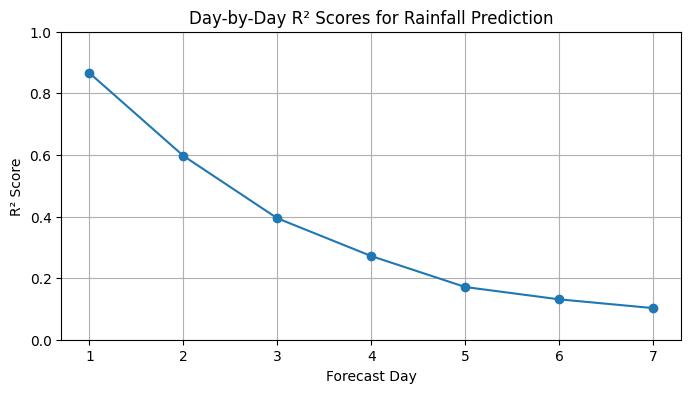

In [ ]:
# Evaluation 
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Predict
y_pred_reg, y_pred_class = model.predict({
    "short_seq": X_test,
    "long_input": X_long_test,
    "wind_input": X_wind_test
})


# unscale
y_pred_reg_unscaled = tp_scaler.inverse_transform(y_pred_reg.reshape(-1, 1)).reshape(y_pred_reg.shape)
y_true_reg_unscaled = tp_scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)

# R² score (flattened)
r2 = r2_score(y_true_reg_unscaled.flatten(), y_pred_reg_unscaled.flatten())
print(f"R² score (unscaled regression): {r2:.3f}")

from sklearn.metrics import classification_report

# Print true and predicted unique classes to debug in case of data splitting errors and shape mismatch (frequent)
print("Unique true labels:", np.unique(y_rain_test.flatten()))
print("Unique predicted classes:", np.unique(y_pred_class.flatten()))

y_pred_classes = np.argmax(y_pred_class, axis=1)
print("Unique predicted classes:", np.unique(y_pred_classes))

# Choose a forecast day (e.g., day 0 = first day)
forecast_day = 0

# Get true labels for that day
y_true_day = y_rain_test[:, forecast_day]  # shape: (12253,)

# Get predicted class probabilities for that day
y_pred_day_probs = y_pred_class[:, forecast_day, :]  # shape: (12253, 4)

# Convert to predicted class labels
y_pred_day_labels = np.argmax(y_pred_day_probs, axis=1)  # shape: (12253,)

# Debug
print("True labels shape:", y_true_day.shape)
print("Predicted labels shape:", y_pred_day_labels.shape)
print("Unique true labels:", np.unique(y_true_day))
print("Unique predicted labels:", np.unique(y_pred_day_labels))

for day in range(forecast_horizon):  # assuming forecast_horizon = 7
    y_true_day = y_rain_test[:, day]
    y_pred_day_probs = y_pred_class[:, day, :]
    y_pred_day_labels = np.argmax(y_pred_day_probs, axis=1)
    
    print(f"\n📅 Day {day+1} Classification Report:")
    print(classification_report(
        y_true_day,
        y_pred_day_labels,
        labels=[0, 1, 2, 3],
        target_names=[
            'No Rain (≤0.1mm)',
            'Light Rain (0.1–2mm)',
            'Moderate Rain (2–10mm)',
            'Heavy Rain (>10mm)'
        ]
    ))



print("y_true_reg_unscaled shape:", y_true_reg_unscaled.shape)
print("y_pred_reg_unscaled shape:", y_pred_reg_unscaled.shape)

print("R² scores for each forecast day (unscaled regression):\n")

for day in range(forecast_horizon):
    r2 = r2_score(
        y_true_reg_unscaled[:, day],
        y_pred_reg_unscaled[:, day]
    )
    print(f"Day {day+1}: R² = {r2:.3f}")



r2_day_scores = [
    r2_score(y_true_reg_unscaled[:, day], y_pred_reg_unscaled[:, day])
    for day in range(7)
]

plt.figure(figsize=(8, 4))
plt.plot(range(1, 8), r2_day_scores, marker='o')
plt.title("Day-by-Day R² Scores for Rainfall Prediction")
plt.xlabel("Forecast Day")
plt.ylabel("R² Score")
plt.grid(True)
plt.xticks(range(1, 8))
plt.ylim(0, 1)
plt.show()

In [ ]:
# Define grid coordinates manually based on your naming convention
region_coords = {
    'n2w2': (0, 0), 'n2w': (0, 1), 'n2': (0, 2), 'n2e': (0, 3), 'n2e2': (0, 4),
    'nw2': (1, 0),  'nw': (1, 1),  'n': (1, 2),  'ne': (1, 3),  'ne2': (1, 4),
    'w2': (2, 0),   'w': (2, 1),   'center': (2, 2), 'e': (2, 3), 'e2': (2, 4),
    'sw2': (3, 0),  'sw': (3, 1),  's': (3, 2),  'se': (3, 3),  'se2': (3, 4),
    's2w2': (4, 0), 's2w': (4, 1), 's2': (4, 2), 's2e': (4, 3), 's2e2': (4, 4),
}
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Choose a timestep to visualize (e.g., middle of the dataset)
timestep = len(df) // 2

# Create a 5x5 array to hold values
heatmap_data = np.full((5, 5), np.nan)

for region, (row, col) in region_coords.items():
    feature_name = f'wind_divergence_{region}' if f'wind_divergence_{region}' in df.columns else None
    if feature_name:
        heatmap_data[row, col] = df.loc[df.index[timestep], feature_name]

plt.figure(figsize=(6, 5))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Wind Divergence'})
plt.title(f"Wind Divergence Heatmap at Timestep {timestep}")
plt.xlabel("E-W")
plt.ylabel("N-S")
plt.show()

U = np.zeros((5, 5))
V = np.zeros((5, 5))

for region, (row, col) in region_coords.items():
    u_col = f'u10_{region}'
    v_col = f'v10_{region}'
    if u_col in df.columns and v_col in df.columns:
        U[row, col] = df.loc[df.index[timestep], u_col]
        V[row, col] = df.loc[df.index[timestep], v_col]

plt.figure(figsize=(6, 6))
plt.quiver(U, V)
plt.title(f"Wind Vectors at Timestep {timestep}")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()
